# Part 1: 5 plots

For the 5 distinct chart types I decided to plot the following data:

- Barcharts: *Counts of products* per *age rating*, *media* and streaming servie.
- Linechart: *Counts of **18+ movies** per **year*** and streaming service.
- Histogram: *Probability Function of the duration of **movies*** per streaming service.
- Scatterplot: *Relation between **duration** and **release year** of a movie per streaming service.
- Piechart: *Proportion of **directors** that have made +18 movies in Netflix*.

## Importing libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from math import isnan, nan

movie_titles: dict[str, pd.DataFrame] = {}
movie_titles["amazon_prime"] = pd.read_csv("./amazon_prime_titles.csv")
movie_titles["disney_plus"] = pd.read_csv("./disney_plus_titles.csv")
movie_titles["hulu"] = pd.read_csv("./hulu_titles.csv")
movie_titles["netflix"] = pd.read_csv("./netflix_titles.csv")

## Data Wrangling/Transformation

In [2]:
AggregatePerMedia = dict[str, dict[str, pd.Series]]
MEDIA = ("TV Show", "Movie")
RATING_LEVELS = {
    "G": "All",
    "PG": "7+",
    "PG-13": "13+",
    "R": "16+",
    "NC-17": "18+",
    "NR": "NR",
    "TV-G": "All",
    "For Children": "For Children",
    "TV-Y": "For Children",
    "TV-Y7": "7+", 
    "TV-Y7-FV": "7+",
    "TV-PG": "7+",
    "TV-14": "13+",
    "TV-16": "16+",
    "TV-MA": "18+",
    "TV-NR": "NR",
    "7+": "7+",
    "13+": "13+",
    "16": "16+",
    "16+":"16+",
    "18+": "18+",
    "ALL_AGES": "All",
    "AGES_16_": "16+",
    "AGES_18_": "18+",
    "ALL": "All",
    "UNRATED": "NR",
    "UR": "NR",
    "NOT_RATE": "NR",
    "NOT RATED": "NR",
}

SERVICE_GRID = (("amazon_prime", "disney_plus"), ("hulu","netflix"))

SERVICE_COLORS = {
    "amazon_prime": "tab:purple",
    "hulu": "tab:green",
    "disney_plus": "tab:blue",
    "netflix": "tab:red"
}

def simplify_rating(rating) -> str:
    return RATING_LEVELS[rating] if rating in RATING_LEVELS else "NR"

def simplify_duration(entry) -> float|int|str:
    if isinstance(entry, float):
        return nan if isnan(entry) else int(entry)
    else:
        return int(entry.split(" ")[0])

for service in movie_titles.values():
    for column, wrangler in zip(
        ("rating", "duration"), (simplify_rating, simplify_duration)
    ):
        service[column] = service[column].apply(wrangler)

## Barchart (1)
### Aggregation

In [3]:
rating_counts: AggregatePerMedia = {service: {} for service in movie_titles}

for service in rating_counts:
    for media in MEDIA:
        rating_counts[service][media] = \
            movie_titles[service][movie_titles[service].type == media].rating \
                .value_counts() \
                .reindex(
                    reversed(["All", "For Children", "7+", "13+", "16+", "18+", "NR"])
                )

### Plotting

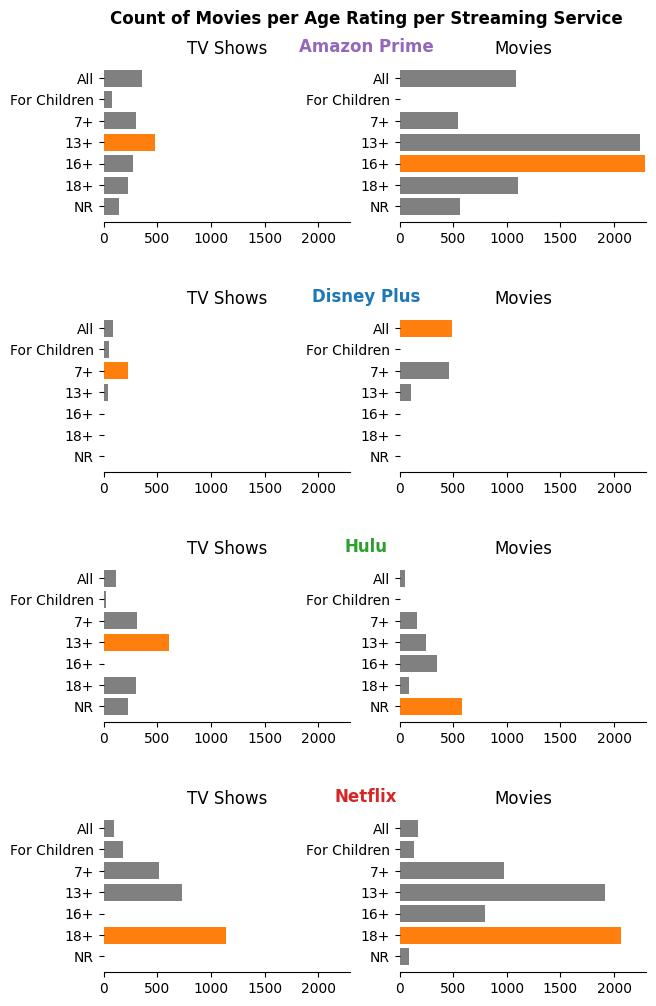

In [4]:
def barcharts():
    fig = plt.figure(figsize=(7,10))
    fig.suptitle("Count of Movies per Age Rating per Streaming Service", weight="bold", y=.99)
    fig.subplots_adjust(hspace=-.25, top=.75)
    gridspec = GridSpec(len(rating_counts), 1, figure=fig)

    for cell, service in zip(gridspec, rating_counts):
        subfigure = fig.add_subfigure(cell)
        service_title = subfigure.suptitle(
            " ".join(service.split("_")).title(),
            weight="bold", y=.85
        )
        service_title.set_color(SERVICE_COLORS[service])

        ax = subfigure.subplots(1,2)

        for axes, media in zip(ax, MEDIA):
            values = rating_counts[service][media]
            index = values.index
            colors_per_value = \
                ['tab:orange' if i == values.idxmax() else 'gray' \
                        for i in index]
            axes.barh(y=index, width=values, color = colors_per_value)
            axes.set_title(media + "s")
            axes.spines[["top", "left", "right"]].set_visible(False)
            axes.set_xlim(xmin=0, xmax=2300)

    plt.show()
barcharts()

## Time Series (2)
### Aggregation

In [5]:
rating_counts_over_years: AggregatePerMedia = \
    {service: {} for service in movie_titles}

for service in rating_counts_over_years:
    for media in MEDIA:
        temp = movie_titles[service][movie_titles[service].type == media] \
                .reindex(columns=["rating", "release_year"])
        rating_counts_over_years[service][media] = \
            temp.groupby("rating") \
                .release_year \
                .value_counts() \
                .unstack()

plus_18_across_services = pd.DataFrame(
    index=['amazon_prime','disney_plus', 'hulu','netflix'],
    columns=np.arange(2003,2023)
)
 
for service_name, service_data in rating_counts_over_years.items():
    if (interest_rating := '18+') in service_data["Movie"].index:
        temp = service_data['Movie'].loc[interest_rating]
        temp.name = service_name
        plus_18_across_services.loc[service_name] = temp

    else:
        plus_18_across_services.loc[service_name] = \
            pd.Series()

### Plotting

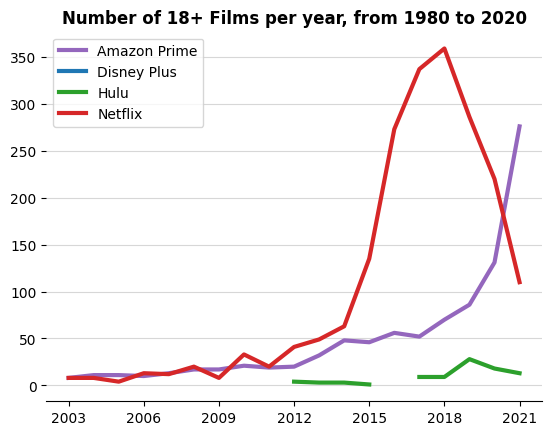

In [6]:
def linecharts():
    for service in plus_18_across_services.index:
        plt.plot(
            plus_18_across_services.loc[service],
            label=" ".join(service.split("_")).title(),
            c=SERVICE_COLORS[service], lw=3
        )
    plt.grid(axis="y", alpha=.5)
    plt.gca().spines[["top", "left", "right"]].set_visible(False)
    # NOTE: gca() is the best!!
    plt.legend()
    plt.xticks(np.arange(2003,2022,3))
    plt.title(
        "Number of 18+ Films per year, from 1980 to 2020",
        weight="bold"
    )
    plt.show()
linecharts()

## Histogram (3)

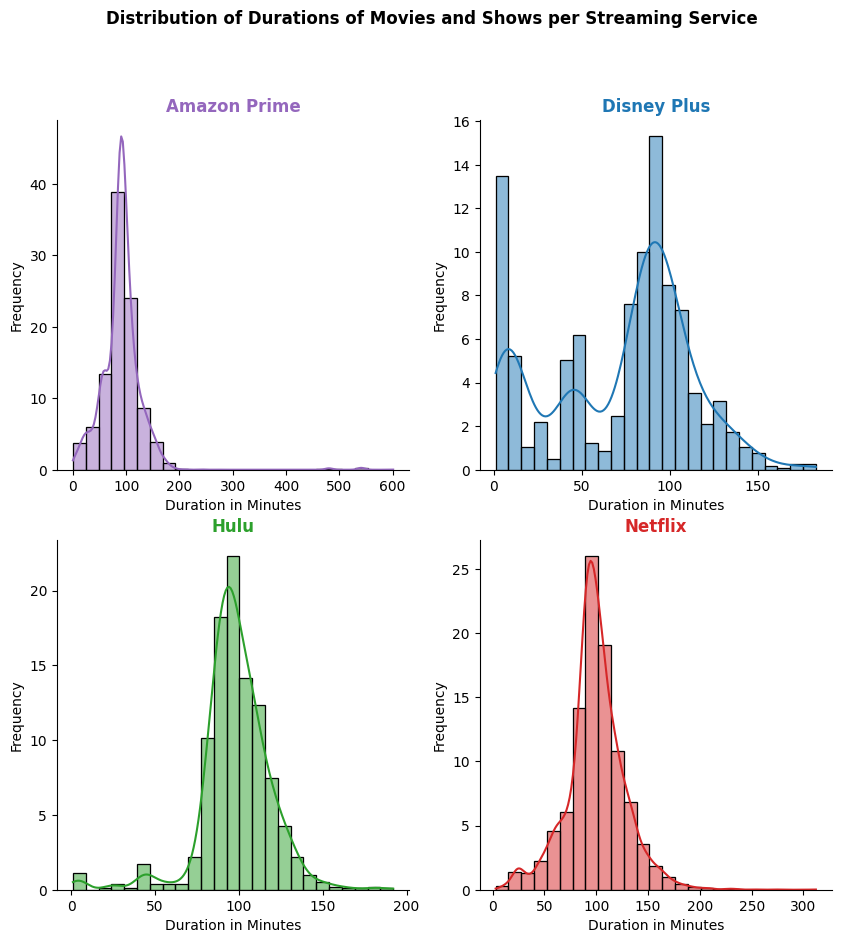

In [7]:
def histograms():
    fig, ax = plt.subplots(2,2,figsize=(10,10))
    fig.suptitle(
        "Distribution of Durations of Movies and Shows per Streaming Service",
        weight="bold", y=.99
    )

    for row_ax, row_serv in zip(ax, SERVICE_GRID):
        for axes, service in zip(row_ax, row_serv):
            data = movie_titles[service][movie_titles[service].type == "Movie"] \
                .duration
            sns.histplot(
                data, bins=25, stat="percent", kde=True, ax=axes,
                color=SERVICE_COLORS[service],
                label= " ".join(service.split("_")).title()
            )
            title = axes.set_title(
                " ".join(service.split("_")).title(), weight="bold"
            )
            title.set_color(SERVICE_COLORS[service])
            axes.set_xlabel("Duration in Minutes")
            axes.set_ylabel("Frequency")
            #axes.set_xlim(xmin=0, xmax=600)
            axes.spines[["top", "right"]].set_visible(False)

    plt.show()
histograms()

## Scatterplot (4)

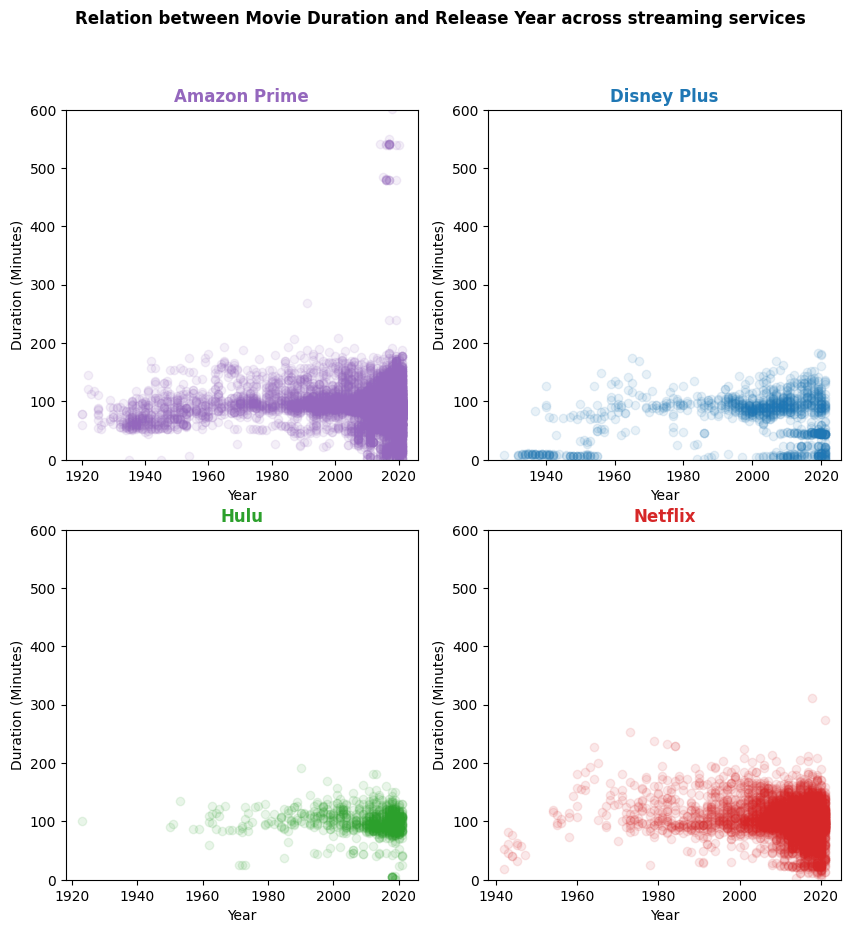

In [8]:
def scatterplots():
    fig, ax = plt.subplots(2,2, figsize=(10,10))

    for axes_row, service_row in zip(ax, SERVICE_GRID):
        for axes, service_name in zip(axes_row, service_row):
            service_data = movie_titles[service_name]
            axes.scatter(
                service_data[service_data.type == "Movie"].release_year,
                service_data[service_data.type == "Movie"].duration,
                alpha=.1, color=SERVICE_COLORS[service_name]
            )
            axes.set_ylabel("Duration (Minutes)")
            axes.set_xlabel("Year")
            axes.set_ylim(ymin=0, ymax=600)
            title = axes.set_title(
                " ".join(service_name.split("_")).title(), weight="bold"
            )
            title.set_color(SERVICE_COLORS[service_name])

    fig.suptitle(
        "Relation between Movie Duration and Release Year across " +
            "streaming services", weight="bold"
    )
    plt.show()

scatterplots()

## Piecharts (5)
### Aggregation

In [9]:
rating_per_director = movie_titles["netflix"][["director", "rating"]] \
    .value_counts() \
    .unstack()
number_18_directors = rating_per_director.loc[:,"18+"].count()
aggregates = [
    number_18_directors,
    len(rating_per_director) - number_18_directors
]

### Plotting

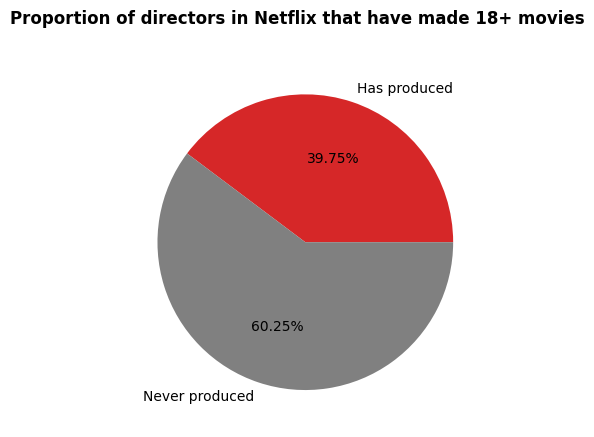

In [10]:
def piecharts():
    plt.pie(
        aggregates, colors = ["tab:red","gray"],
        labels = ["Has produced", "Never produced"],
        autopct= lambda x: f"{x:.2f}%"
    )

    plt.suptitle(
        "Proportion of directors in Netflix that have made 18+ movies",
        weight="bold"
    )
    plt.show()
piecharts()

# Other plots and code